In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd 'drive/My Drive/secom'

In [38]:
# import relevant libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import Lasso
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA

In [39]:
!pip install factor_analyzer

In [40]:
!pip install --upgrade boruta

In [76]:
## define functions to be used downstream

def analyze_outliers_iqr(df):
  """
  takes a pandas dataframe to analyze outliers with IQR method
  returns an outlier report (pandas dataframe) with below columns
  col_name	num_outliers	mean_IQR_dev
  Also visualize num-of outliers and average deviation from the mean in outliers
  """
  out_report = []
  for colm in df.columns:
    col_series = df[colm]
    q1 = col_series.quantile(0.25)
    col_series_mean = col_series.mean()
    q3 = col_series.quantile(0.75)
    IQR = q3-q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    out_series =  col_series[((col_series > upper_fence) | (col_series < lower_fence))] # keep only the outliers
    out_series = (out_series - col_series_mean) / IQR  # transform to "how many IQR the observation is away from mean"
    out_report.append((colm,out_series.shape[0],abs(out_series).mean()))
  out_report_df = pd.DataFrame(out_report,columns=['col_name','num_outliers','mean_IQR_dev'])
  sns.scatterplot(data=out_report_df, x = 'num_outliers', y = 'mean_IQR_dev')
  return out_report_df

def analyze_outliers_z_score(df):
  """
  takes a pandas dataframe to analyze outliers with z-score method
  returns an outlier report (pandas dataframe) with below columns
  col_name	num_outliers	mean_z_dev
  Also visualize num-of outliers and average deviation from the mean in outliers
  """
  out_report = []
  for colm in df.columns:
    col_series = df[colm]
    mean = col_series.mean()
    std = col_series.std()
    out_series = (col_series - mean) / std # new series with z-score
    out_series = out_series[abs(out_series) > 3]
    out_report.append((colm,out_series.shape[0],abs(out_series).mean()))
  out_report_df = pd.DataFrame(out_report,columns=['col_name','num_outliers','mean_z_dev'])
  sns.scatterplot(data=out_report_df, x = 'num_outliers', y = 'mean_z_dev')
  return out_report_df

def replace_outliers_with_3s_boundary(data):
    """
    takes a dataframe and replaces the outliers (z-score method) with 3s boundry
    also returns the fitterd standard scaler
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    z_scores = scaled_data
    outliers_positive = z_scores > 3
    outliers_negative = z_scores < -3
    scaled_data[outliers_positive] = 3
    scaled_data[outliers_negative] = -3
    data_cleaned = scaler.inverse_transform(scaled_data)
    data_cleaned = pd.DataFrame(data_cleaned, columns=data.columns)
    return data_cleaned, scaler

#//ABANDON//
def get_correlated_features_to_drop(df,threshold):
  """
  returns a list of features that can be dropped from training dataframe due to high correlation
  ensures that one feature of correlated pairs remains in the dataset
  """
  corr_features_to_drop = []
  corr_matrix = df.corr()
  num_features = corr_matrix.shape[0]
  for i_row in range(0,num_features-1):
    for j_col in range(i_row + 1,num_features):
      if abs(corr_matrix.iloc[i_row,j_col]) > threshold:
        if ((corr_matrix.columns[i_row] not in corr_features_to_drop) & (corr_matrix.columns[j_col] not in corr_features_to_drop)):
          corr_features_to_drop.append(corr_matrix.columns[j_col])
  return corr_features_to_drop

def boruta_feature_selection(X,y):
  """
  runs boruta feature selection technique
  returns a list of selected features
  """
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
  np.int = np.int32 # workaround for np.int deprcation
  np.float = np.float64 # likewise
  np.bool = np.bool_ # likewise
  boruta_selector.fit(X.values, y.values)
  return boruta_selector.support_
  #selected_features = X_train_cleaned_imputed.columns[boruta_selector.support_].to_list()
  #return selected_features

def lasso_feature_selection(X,y):
  """
  returns a set of features as selected by Lasso regression approach
  """
  lasso_clf = Lasso(alpha = 0.1)
  lasso_clf.fit(X, y)
  feature_importance = pd.Series(lasso_clf.coef_,index=X.columns)
  selected_features = feature_importance[feature_importance != 0].index.to_list()
  return selected_features

def KMO(X):
    kmo_all, kmo_model = calculate_kmo(X)
    print(f"KMO overall: {kmo_model}")
    if kmo_model >= 0.6:
        print("The data is suitable for PCA")
    else:
        print("The data is not suitable for PCA")
    return kmo_model


def pca_selection(X_train,X_test,variation_to_capture):
  """
  returns 2 transformed DFs (one each for X_train and X_test) with principal components to
  capture only a given
  percentage of variation
  """
  pca = PCA().fit(X_train)
  explained_variance = pca.explained_variance_ratio_
  #  create cumulative varince list
  explained_variance_cume = []
  counter = 0
  for i in explained_variance:
    explained_variance_cume.append(counter + i)
    counter = counter + i
  # display the scree plot
  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
  plt.title('Scree Plot')
  plt.xlabel('Principal Component')
  plt.ylabel('Eigenvalue')
  plt.show()
  plt.plot(PC_values, explained_variance_cume, 'o-', linewidth=2, color='blue')
  plt.title('Cumulative Explained Variance')
  plt.axhline(y=0.85, color='r', linestyle='--', label='85% Explained Variance')
  plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
  plt.xlabel('Principal Component')
  plt.ylabel('Cumulative Variance Explained')
  plt.legend()
  plt.show()
  # get required no. of components
  num_components = len([item for item in explained_variance_cume if item <= variation_to_capture])
  print("PCA - returning {} componsnts to capture {} % variation".format(num_components,variation_to_capture*100))
  # pca to produce only the required no. of components
  pca_2 = PCA(n_components=num_components)
  pca_2.fit(X_train)
  return pd.DataFrame(pca_2.transform(X_train),columns=["PC"+str(i) for i in range(1,num_components+1)]),\
         pd.DataFrame(pca_2.transform(X_test),columns=["PC"+str(i) for i in range(1,num_components+1)])


def fit_evaluate_baseline_rf_classifier(X_train,y_train,X_test,y_test):
  """
  Fits a baseline RF model, and returns performs metrics on test dataset.
  """
  rf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state = 42)
  rf_clf.fit(X_train,y_train)
  y_pred = rf_clf.predict(X_test)
  tpr,fpr,_ = roc_curve(y_test,y_pred)
  return accuracy_score(y_test,y_pred), \
         precision_score(y_test,y_pred), \
         recall_score(y_test,y_pred), \
         f1_score(y_test,y_pred), \
         confusion_matrix(y_test,y_pred), \
         roc_auc_score(y_test,y_pred), \
         tpr, \
         fpr

def mice_imputer_train_test(X_train,X_test):
  mice_imputer = IterativeImputer(random_state=42)
  X_train_mice = pd.DataFrame(mice_imputer.fit_transform(X_train),columns=X_train.columns)
  X_test_mice = pd.DataFrame(mice_imputer.transform(X_test),columns=X_test.columns)
  return X_train_mice, X_test_mice

def knn_imputer_train_test(X_train,X_test):
  knn_imputer = KNNImputer(n_neighbors=5)
  X_train_knn = pd.DataFrame(knn_imputer.fit_transform(X_train),columns=X_train.columns)
  X_test_knn = pd.DataFrame(knn_imputer.transform(X_test),columns=X_test.columns)
  return X_train_knn, X_test_knn

def adasyn_oversampler(X,y):
  adasyn = ADASYN(random_state=42)
  X_adasyn, y_adasyn = adasyn.fit_resample(X,y)
  print("ADASYN Class Balancing")
  print("Class balance before- ", sorted(Counter(y).items()))
  print("Class balance after - ", sorted(Counter(y_adasyn).items()))
  return X_adasyn, y_adasyn

def smote_oversampler(X,y):
  smote = SMOTE(random_state=42)
  X_smote, y_smote = smote.fit_resample(X,y)
  print("SMOTE Class Balancing")
  print("Class balance before- ", sorted(Counter(y).items()))
  print("Class balance after - ", sorted(Counter(y_smote).items()))
  return X_smote, y_smote

In [73]:
#def calculate_error_cost(confusion_matrix, cost_type1=20, cost_type2=1): to be checked
    """
    Calculate the total error cost based on the confusion matrix.
    
    Parameters:
    confusion_matrix (array-like): Confusion matrix of the model.
    cost_type1 (float): Cost of Type I error (False Positive).
    cost_type2 (float): Cost of Type II error (False Negative).
    
    Returns:
    float: Total error cost.
    """
    TN, FP, FN, TP = confusion_matrix.ravel()
    type1_error_cost = FP * cost_type1
    type2_error_cost = FN * cost_type2
    total_error_cost = type1_error_cost + type2_error_cost
    return total_error_cost

In [21]:
# load data, merge, rename columns, remove timestamp
df = pd.read_csv(r'C:\Users\JingKang\Desktop\case study\secom\secom.data', delim_whitespace=True, header=None)
timestamps_df = pd.read_csv(r'C:\Users\JingKang\Desktop\case study\secom\secom_labels.data', delim_whitespace=True, header=None)
combined_df = pd.concat([timestamps_df, df], axis=1)
combined_df.columns = ['target','ts'] + [f'feature{i}' for i in range(1, df.shape[1] + 1)]
combined_df.drop(['ts'],axis=1,inplace=True) # we might not want to use date-time as a predictor

In [22]:
# train and test split
target_value = combined_df.pop("target")
X_train, X_test, y_train, y_test = train_test_split(combined_df, target_value, test_size=0.25, random_state=42, stratify=target_value)
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Number of Features:", X_train.shape[1])
print("Class balance before split- ", sorted(Counter(timestamps_df.iloc[:,0]).items()))
print("class balance after split (training)- ", sorted(Counter(y_train).items()))
print("class balance after split (test)- ", sorted(Counter(y_test).items()))

Training set size: 1175
Test set size: 392
Number of Features: 590
Class balance before split-  [(-1, 1463), (1, 104)]
class balance after split (training)-  [(-1, 1097), (1, 78)]
class balance after split (test)-  [(-1, 366), (1, 26)]


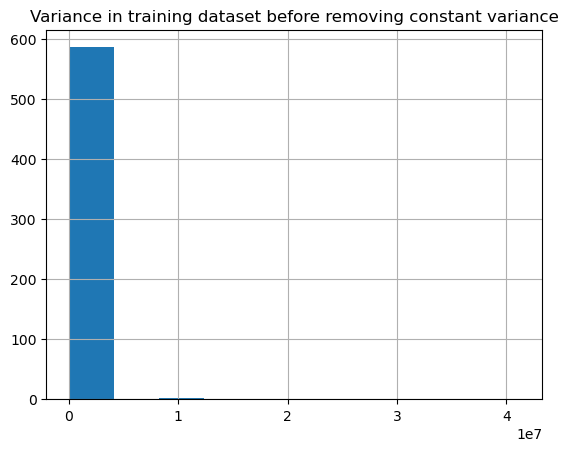

Number of Features: 474


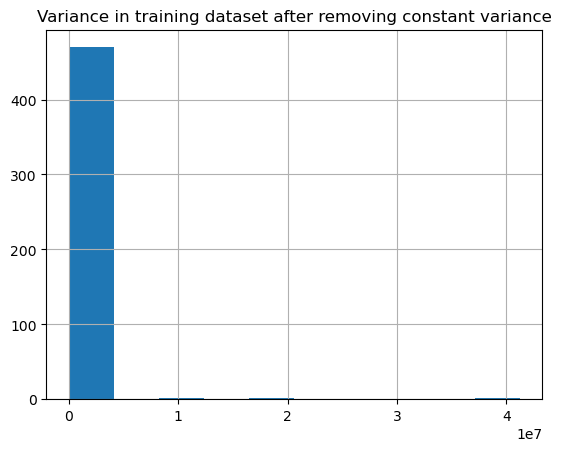

In [23]:
X_train.var().hist()
plt.title('Variance in training dataset before removing constant variance')
plt.show()

# drop features with no variances
variances_in_train_set = X_train.var()
X_train = X_train.loc[:, variances_in_train_set != 0]

#if using the same method to clean the no variance feature in x test set, the result is different from that of x train
X_test = X_test[X_train.columns]
print("Number of Features:", X_train.shape[1])

X_train.var().hist()
plt.title('Variance in training dataset after removing constant variance')
plt.show()

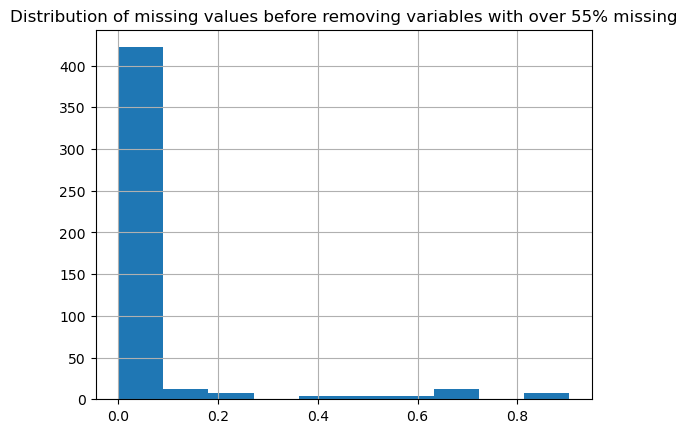

Number of Features remaining after removing features with missing over 55%: 450


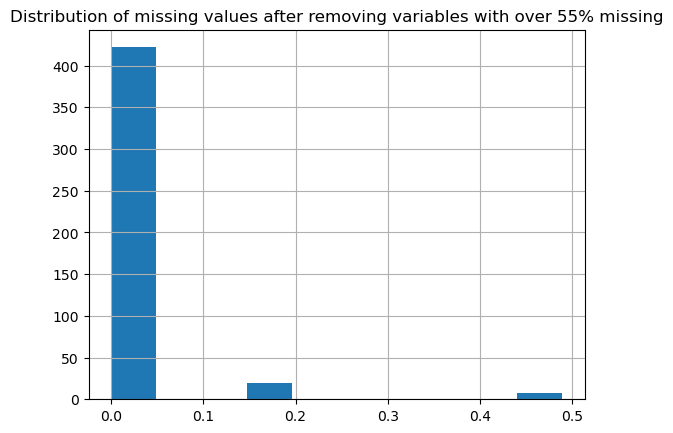

In [24]:
# drop features with missing value ratio larger than 55%
missing_value_ratio = X_train.isna().mean()
missing_value_ratio.hist()
plt.title('Distribution of missing values before removing variables with over 55% missing')
plt.show()

columns_to_keep = missing_value_ratio[missing_value_ratio < 0.55].index
X_train = X_train[columns_to_keep]
X_test = X_test[X_train.columns]
print("Number of Features remaining after removing features with missing over 55%:", X_train.shape[1])

missing_value_ratio = X_train.isna().mean()
missing_value_ratio.hist()
plt.title('Distribution of missing values after removing variables with over 55% missing')
plt.show()

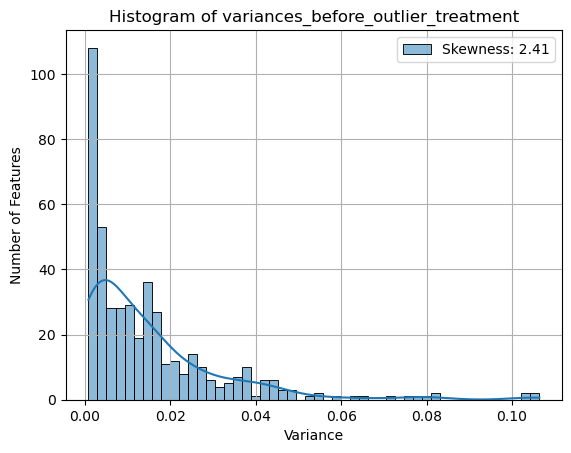

In [25]:
normalized_X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
variances_before_outlier_treatment = normalized_X_train.var()
sns.histplot(variances_before_outlier_treatment.values, bins=50, kde=True, label='Skewness: %.2f' % (variances_before_outlier_treatment.skew()))
plt.title('Histogram of variances_before_outlier_treatment')
plt.xlabel('Variance')
plt.ylabel('Number of Features')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

### Outliers Visualization

Many extreme outliers, Some of these may by influential observations, than outliers. Hence it is prudent that we  cap outliers using 3s approach and not IQR

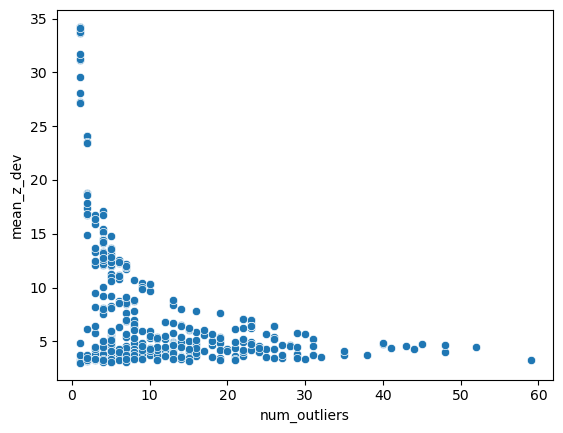

In [26]:
z_score_out = analyze_outliers_z_score(X_train)

### in many cases there are extreme outliers that are over 5

In [27]:
X_train_3s, fitted_scaler = replace_outliers_with_3s_boundary(X_train)
# X_test_3s = replace_outliers_with_3s_boundary(X_test) # tbd to be corrected later

# use the fitted scale to treat outliers in testing dataset
z_scores = fitted_scaler.transform(X_test)
outliers_positive = z_scores > 3
outliers_negative = z_scores < -3
z_scores[outliers_positive] = 3
z_scores[outliers_negative] = -3
X_test_3s = fitted_scaler.inverse_transform(z_scores)
X_test_3s = pd.DataFrame(X_test_3s, columns=X_test.columns)

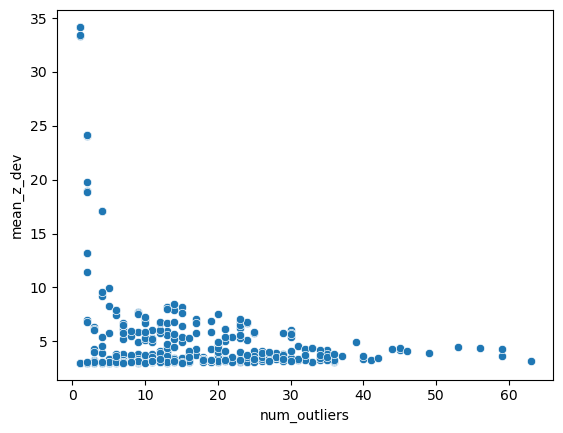

In [28]:
z_score_out_3s = analyze_outliers_z_score(X_train_3s)

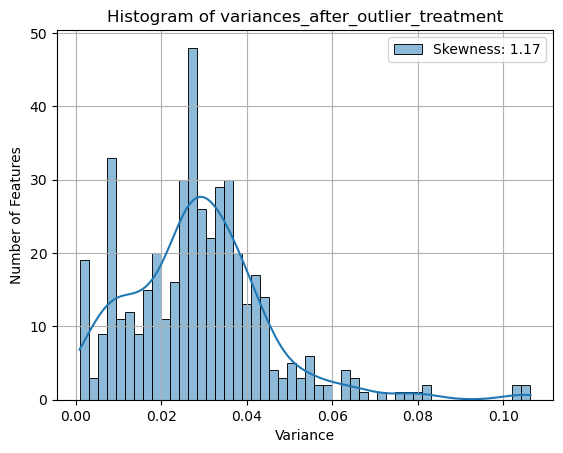

In [32]:
normalized_X_train_3s = (X_train_3s - X_train_3s.min()) / (X_train_3s.max() - X_train_3s.min())
variances_after_outlier_treatment = normalized_X_train_3s.var()
sns.histplot(variances_after_outlier_treatment.values, bins=50, kde=True, label='Skewness: %.2f' % (variances_after_outlier_treatment.skew()))
plt.title('Histogram of variances_after_outlier_treatment')
plt.xlabel('Variance')
plt.ylabel('Number of Features')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

### Trying different imputation techniques and comparing them. Since some of the techniques like Knn are distance based, we have to scale the data. We add noise to the data (Random NAs) to be able to compare different imputation methods.

In [33]:
# add randomly 5% NAs to training set
np.random.seed(42)
X_train_3s_copy = X_train_3s.copy()
# Create a boolean mask to identify existing missing values
existing_missing_mask = X_train_3s_copy.isnull()
# Generate a random boolean mask of the same shape as existing one
additional_missing_mask = (np.random.rand(*X_train_3s_copy.shape) < 0.05)
# note down the position of new NAs
new_missing_mask = additional_missing_mask & ~existing_missing_mask

combined_missing_mask = existing_missing_mask | additional_missing_mask
# Apply the mask to create a dataset with missing values
X_train_3s_noisy = X_train_3s.mask(combined_missing_mask)

# scale using min-max scaler
scaler = MinMaxScaler()
X_train_3s_noisy_scaled = scaler.fit_transform(X_train_3s_noisy)

# kNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
X_train_3s_noisy_knn_filled = knn_imputer.fit_transform(X_train_3s_noisy_scaled)
X_train_3s_noisy_knn_filled_original = scaler.inverse_transform(X_train_3s_noisy_knn_filled)


# MICE imputation
mice_imputer = IterativeImputer(random_state=42)
X_train_3s_noisy_mice_filled = mice_imputer.fit_transform(X_train_3s_noisy_scaled)
X_train_3s_noisy_mice_filled_original = scaler.inverse_transform(X_train_3s_noisy_mice_filled)

# Record the location of the newly introduced missing values
new_missing_positions = np.where(new_missing_mask)

original_values = X_train_3s_copy.values[new_missing_positions]
knn_filled_values = X_train_3s_noisy_knn_filled_original[new_missing_positions]
mice_filled_values = X_train_3s_noisy_mice_filled_original[new_missing_positions]

knn_mse = mean_squared_error(original_values, knn_filled_values)
mice_mse = mean_squared_error(original_values, mice_filled_values)

print(f'Sum of squared differences for kNN imputation (only for new missing values): {knn_mse}')
print(f'Sum of squared differences for MICE imputation (only for new missing values): {mice_mse}')

Sum of squared differences for kNN imputation (only for new missing values): 145469.14167012362
Sum of squared differences for MICE imputation (only for new missing values): 26985.838100001027


C:\Users\JingKang\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [34]:
# Scale the data, since some of the methods that we might use downstream are distance based

mm_scaler = MinMaxScaler()
X_train_3s_MM_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train_3s),columns=X_train_3s.columns)
X_test_3s_MM_scaled = pd.DataFrame(mm_scaler.transform(X_test_3s), columns=X_test_3s.columns)

In [35]:
X_train_selected = X_train_3s_MM_scaled
X_test_selected = X_test_3s_MM_scaled

In [36]:
# We will try below techniques
# Imputation - KNN, MICE
# Class imbalance - ADASYN, SMOTE
# Feature Selection / Reduction - Boruta, PCA, Factor
# Baseline classfier with Random Forest method

model_results_list=[]

In [46]:
### Model 1 - "kNN Imputation"-"BORUTA selection"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02



# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_01",
                 ("KNN Imputation", "ADASYN balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1083)]
('model_01', ('KNN Imputation', 'ADASYN balancing', 'BORUTA selection'), 'baseline RF classifier', 0.875, 0.17142857142857143, 0.23076923076923078, 0.19672131147540983, array([[337,  29],
       [ 20,   6]], dtype=int64), 0.5757671290458176, array([0.        , 0.07923497, 1.        ]), array([0.        , 0.23076923, 1.        ]))


In [47]:
boruta_features

['feature60',
 'feature65',
 'feature66',
 'feature104',
 'feature427',
 'feature442',
 'feature563',
 'feature575']

C:\Users\JingKang\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO overall: 0.6842975387008048
The data is suitable for PCA


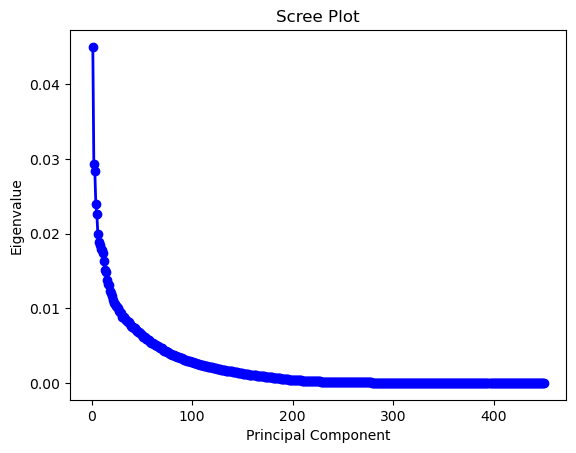

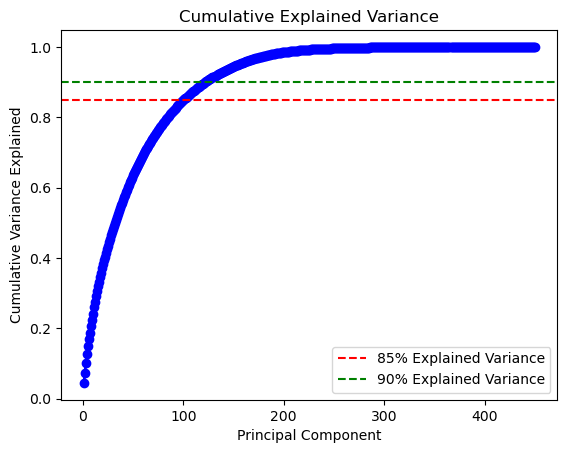

PCA - returning 61 componsnts to capture 70.0 % variation
ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1084)]
('model_02', ('KNN Imputation', 'ADASYN balancing', 'PCA selection'), 'baseline RF classifier', 0.9158163265306123, 0.18181818181818182, 0.07692307692307693, 0.10810810810810811, array([[357,   9],
       [ 24,   2]], dtype=int64), 0.5261664564943253, array([0.        , 0.02459016, 1.        ]), array([0.        , 0.07692308, 1.        ]))


In [59]:
### Model 2 - "kNN Imputation"-"PCA reduction"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# check data adequacy for PCA
kmo_model = KMO(X_train_01)


# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01


# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02


# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_02",
                 ("KNN Imputation", "ADASYN balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [60]:
### Model 3 - "KNN Imputation"-"BORUTA selection"-"SMOTE balancing", 
## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_03",
                 ("KNN Imputation", "SMOTE balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_03', ('KNN Imputation', 'SMOTE balancing', 'BORUTA selection'), 'baseline RF classifier', 0.8928571428571429, 0.25, 0.3076923076923077, 0.27586206896551724, array([[342,  24],
       [ 18,   8]], dtype=int64), 0.6210592686002522, array([0.        , 0.06557377, 1.        ]), array([0.        , 0.30769231, 1.        ]))


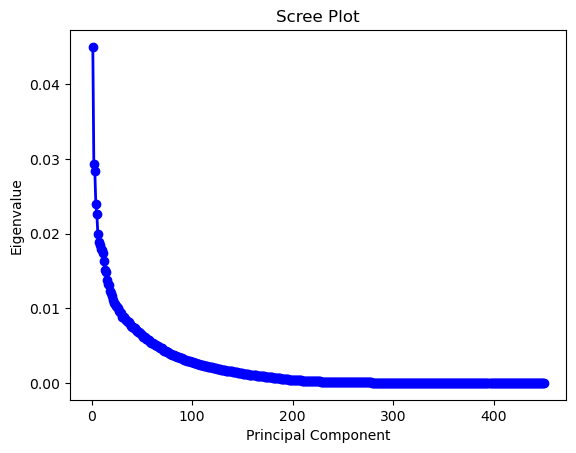

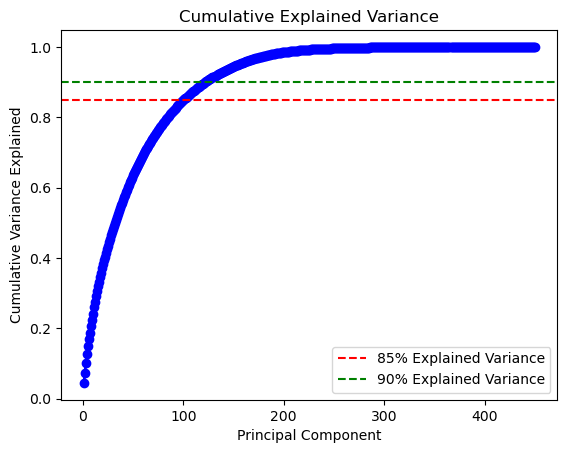

PCA - returning 61 componsnts to capture 70.0 % variation
SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_04', ('KNN Imputation', 'SMOTE balancing', 'PCA selection'), 'baseline RF classifier', 0.9132653061224489, 0.16666666666666666, 0.07692307692307693, 0.10526315789473684, array([[356,  10],
       [ 24,   2]], dtype=int64), 0.5248003362757461, array([0.       , 0.0273224, 1.       ]), array([0.        , 0.07692308, 1.        ]))


In [63]:
### Model 4 - "KNN Imputation"-"PCA selection"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =knn_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test


# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_04",
                 ("KNN Imputation", "SMOTE balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [64]:
### Model 5 - "MICE Imputation"-"BORUTA selection"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute
X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_05",
                 ("MICE Imputation", "ADASYN balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

C:\Users\JingKang\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1068)]
('model_05', ('MICE Imputation', 'ADASYN balancing', 'BORUTA selection'), 'baseline RF classifier', 0.8775510204081632, 0.13333333333333333, 0.15384615384615385, 0.14285714285714285, array([[340,  26],
       [ 22,   4]], dtype=int64), 0.5414039512400168, array([0.        , 0.07103825, 1.        ]), array([0.        , 0.15384615, 1.        ]))


In [65]:
boruta_features

['feature60',
 'feature65',
 'feature66',
 'feature104',
 'feature427',
 'feature442',
 'feature563',
 'feature575']

C:\Users\JingKang\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO overall: 0.6726012527541437
The data is suitable for PCA


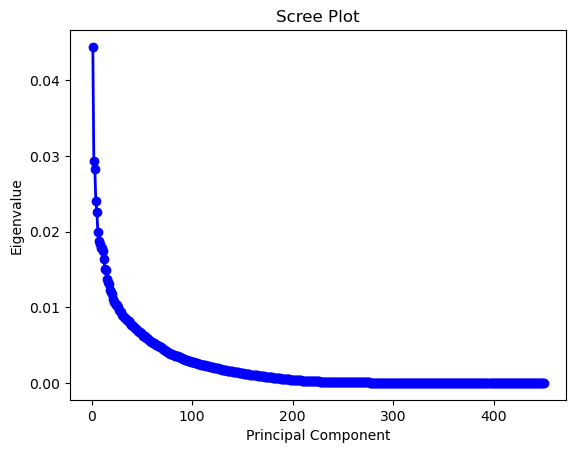

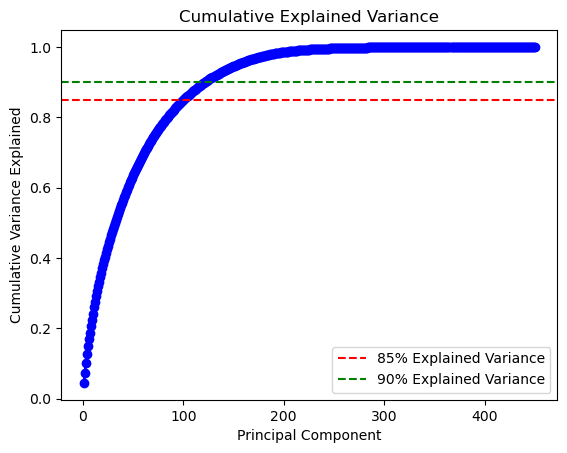

PCA - returning 61 componsnts to capture 70.0 % variation
ADASYN Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1088)]
('model_06', ('MICE Imputation', 'ADASYN balancing', 'PCA selection'), 'baseline RF classifier', 0.9107142857142857, 0.15384615384615385, 0.07692307692307693, 0.10256410256410256, array([[355,  11],
       [ 24,   2]], dtype=int64), 0.5234342160571669, array([0.        , 0.03005464, 1.        ]), array([0.        , 0.07692308, 1.        ]))


In [66]:
### Model 6 - "MICE Imputation"-"PCA reduction"-"ADASYN balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test


# check data adequacy for PCA
kmo_model = KMO(X_train_01)

# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = adasyn_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_06",
                 ("MICE Imputation", "ADASYN balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [67]:
### Model 7 - "MICE Imputation"-"BORUTA reduction"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
boruta_output =  boruta_feature_selection(X_train_01,y_train_01)
boruta_features = X_train_01.columns[boruta_output].to_list()
X_train_02 = X_train_01[boruta_features]
X_test_02 = X_test_01[boruta_features]
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_07",
                 ("MICE Imputation", "SMOTE balancing", "BORUTA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_07', ('MICE Imputation', 'SMOTE balancing', 'BORUTA selection'), 'baseline RF classifier', 0.9005102040816326, 0.21739130434782608, 0.19230769230769232, 0.20408163265306123, array([[348,  18],
       [ 21,   5]], dtype=int64), 0.5715636822194199, array([0.        , 0.04918033, 1.        ]), array([0.        , 0.19230769, 1.        ]))


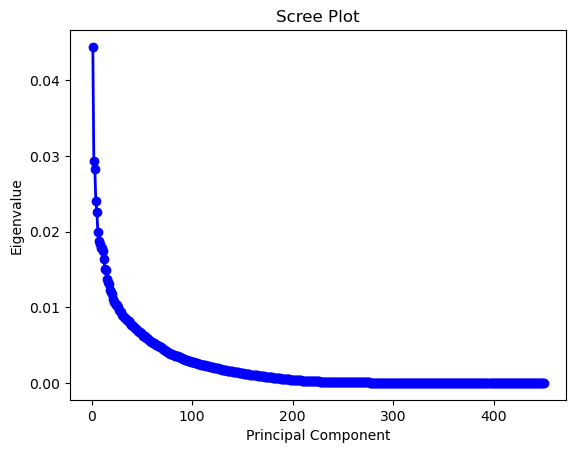

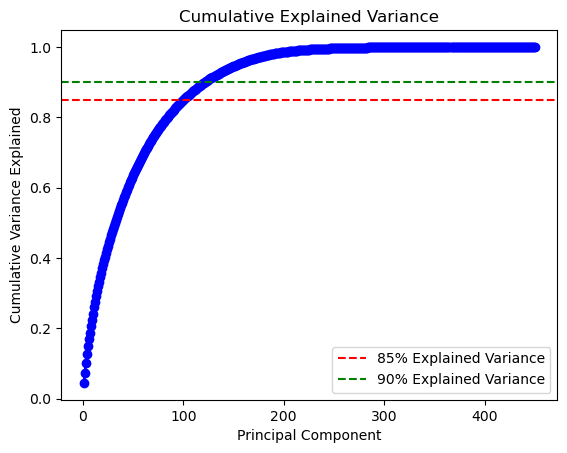

PCA - returning 61 componsnts to capture 70.0 % variation
SMOTE Class Balancing
Class balance before-  [(-1, 1097), (1, 78)]
Class balance after -  [(-1, 1097), (1, 1097)]
('model_08', ('MICE Imputation', 'SMOTE balancing', 'PCA selection'), 'baseline RF classifier', 0.9209183673469388, 0.2727272727272727, 0.11538461538461539, 0.16216216216216217, array([[358,   8],
       [ 23,   3]], dtype=int64), 0.5467633459436738, array([0.        , 0.02185792, 1.        ]), array([0.        , 0.11538462, 1.        ]))


In [68]:
### Model 8 - "MICE Imputation"-"PCA reduction"-"SMOTE balancing", 

## at this point we start with X_train_selected, y_train and X_test_selected and y_test

# impute - Since mice imputer takes time to runn, we can reuse the imputation from model 7 in the script above
# X_train_01, X_test_01 =mice_imputer_train_test(X_train_selected,X_test_selected)
y_train_01 = y_train
y_test_01 = y_test

# feature selection / reduction
X_train_02,X_test_02  =  pca_selection(X_train_01,X_test_01,0.7)
y_train_02 = y_train_01
y_test_02 = y_test_01

# class balancing
X_train_03, y_train_03 = smote_oversampler(X_train_02,y_train_02)
X_test_03 = X_test_02
y_test_03 = y_test_02

# random forest model
accuracy_, precision_, recall_, f1_, confusion_matrix_, roc_auc_, tpr_, fpr_  = fit_evaluate_baseline_rf_classifier(X_train_03,y_train_03,X_test_03,y_test_03)
model_results = ("model_08",
                ( "MICE Imputation", "SMOTE balancing", "PCA selection"),
                 "baseline RF classifier",
                 accuracy_,
                 precision_,
                 recall_,
                 f1_,
                 confusion_matrix_,
                roc_auc_,
                 tpr_,
                 fpr_)
model_results_list.append(model_results)
print(model_results)

In [80]:
# create a dataframe of model results.
model_results_df = pd.DataFrame(model_results_list,
                                columns = ['Model name',
                                           'CRISP DM Decisions',
                                           'Technique',
                                           'Accuracy',
                                           'Precision',
                                           'Recall',
                                           'F1',
                                           'Confusion Matrix',
                                           'ROC AUC',
                                           "TPR",
                                           "FPR"]
                                            )
# Display the results
model_results_df.head()

,Model name,CRISP DM Decisions,Technique,Accuracy,Precision,Recall,F1,Confusion Matrix,ROC AUC,TPR,FPR
0,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
1,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.926020,0.333333,0.115385,0.171429,"[[360, 6], [23, 3]]",0.549496,"[0.0, 0.01639344262295082, 1.0]","[0.0, 0.11538461538461539, 1.0]"
2,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
3,model_04,"(KNN Imputation, SMOTE balancing, PCA selection)",baseline RF classifier,0.920918,0.272727,0.115385,0.162162,"[[358, 8], [23, 3]]",0.546763,"[0.0, 0.02185792349726776, 1.0]","[0.0, 0.11538461538461539, 1.0]"
4,model_05,"(MICE Imputation, ADASYN balancing, BORUTA sel...",baseline RF classifier,0.877551,0.133333,0.153846,0.142857,"[[340, 26], [22, 4]]",0.541404,"[0.0, 0.07103825136612021, 1.0]","[0.0, 0.15384615384615385, 1.0]"


In [77]:
model_results_df.sort_values(by=["ROC AUC"],ascending=False)

,Model name,CRISP DM Decisions,Technique,Accuracy,Precision,Recall,F1,Confusion Matrix,ROC AUC,TPR,FPR
2,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
11,model_03,"(KNN Imputation, SMOTE balancing, BORUTA selec...",baseline RF classifier,0.892857,0.250000,0.307692,0.275862,"[[342, 24], [18, 8]]",0.621059,"[0.0, 0.06557377049180328, 1.0]","[0.0, 0.3076923076923077, 1.0]"
0,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
5,model_01,"(KNN Imputation, ADASYN balancing, BORUTA sele...",baseline RF classifier,0.875000,0.171429,0.230769,0.196721,"[[337, 29], [20, 6]]",0.575767,"[0.0, 0.07923497267759563, 1.0]","[0.0, 0.23076923076923078, 1.0]"
17,model_07,"(MICE Imputation, SMOTE balancing, BORUTA sele...",baseline RF classifier,0.900510,0.217391,0.192308,0.204082,"[[348, 18], [21, 5]]",0.571564,"[0.0, 0.04918032786885246, 1.0]","[0.0, 0.19230769230769232, 1.0]"
9,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.920918,0.307692,0.153846,0.205128,"[[357, 9], [22, 4]]",0.564628,"[0.0, 0.02459016393442623, 1.0]","[0.0, 0.15384615384615385, 1.0]"
7,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.918367,0.285714,0.153846,0.200000,"[[356, 10], [22, 4]]",0.563262,"[0.0, 0.0273224043715847, 1.0]","[0.0, 0.15384615384615385, 1.0]"
12,model_04,"(KNN Imputation, SMOTE balancing, PCA selection)",baseline RF classifier,0.913265,0.250000,0.153846,0.190476,"[[354, 12], [22, 4]]",0.560530,"[0.0, 0.03278688524590164, 1.0]","[0.0, 0.15384615384615385, 1.0]"
8,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.908163,0.222222,0.153846,0.181818,"[[352, 14], [22, 4]]",0.557797,"[0.0, 0.03825136612021858, 1.0]","[0.0, 0.15384615384615385, 1.0]"
1,model_02,"(KNN Imputation, ADASYN balancing, PCA selection)",baseline RF classifier,0.926020,0.333333,0.115385,0.171429,"[[360, 6], [23, 3]]",0.549496,"[0.0, 0.01639344262295082, 1.0]","[0.0, 0.11538461538461539, 1.0]"


In [ ]:
# print_confusion_matrix for all the models

num_models = model_results_df.shape[0]
fig,axs = plt.subplots(figsize = (8,num_models * 5), nrows=num_models)
for ind,row in model_results_df.iterrows():
  model_name = row['Model name'].replace("model","Mod")
  cm = row['Confusion Matrix']
  ConfusionMatrixDisplay(cm,display_labels=[model_name + ' -1', model_name + '  1']).plot(ax = axs[ind])
plt.show()

In [72]:
## display relevant variables form the table
model_results_df[['CRISP DM Decisions', 'Accuracy','Precision', 'Recall','F1','ROC AUC']].sort_values(by='ROC AUC',ascending=False)


,CRISP DM Decisions,Accuracy,Precision,Recall,F1,ROC AUC
2,"(KNN Imputation, SMOTE balancing, BORUTA selec...",0.892857,0.250000,0.307692,0.275862,0.621059
11,"(KNN Imputation, SMOTE balancing, BORUTA selec...",0.892857,0.250000,0.307692,0.275862,0.621059
0,"(KNN Imputation, ADASYN balancing, BORUTA sele...",0.875000,0.171429,0.230769,0.196721,0.575767
5,"(KNN Imputation, ADASYN balancing, BORUTA sele...",0.875000,0.171429,0.230769,0.196721,0.575767
17,"(MICE Imputation, SMOTE balancing, BORUTA sele...",0.900510,0.217391,0.192308,0.204082,0.571564
9,"(KNN Imputation, ADASYN balancing, PCA selection)",0.920918,0.307692,0.153846,0.205128,0.564628
7,"(KNN Imputation, ADASYN balancing, PCA selection)",0.918367,0.285714,0.153846,0.200000,0.563262
12,"(KNN Imputation, SMOTE balancing, PCA selection)",0.913265,0.250000,0.153846,0.190476,0.560530
8,"(KNN Imputation, ADASYN balancing, PCA selection)",0.908163,0.222222,0.153846,0.181818,0.557797
1,"(KNN Imputation, ADASYN balancing, PCA selection)",0.926020,0.333333,0.115385,0.171429,0.549496
